In [1]:
%load_ext autoreload
%autoreload 2

In [178]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

import RaTag.dataIO as dataIO 
from RaTag.datatypes import *
import RaTag.config as config
import RaTag.transport as transport
import RaTag.plotting as plotting
import RaTag.constructors as constructors
import RaTag.analysis as analysis
import RaTag.transformations as transf
from RaTag.xray_integration import *
from RaTag.xray_calibration import fit_xray_histogram

In [3]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')

In [8]:
run5 = Run(
    root_directory = base_dir,
    run_id = "RUN5",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 1e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20                # µs 
)

run5 = constructors.populate_run(run5)
run5 = transport.with_gas_density(run5)

def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=20, batch_size=20, flag_plot=False)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

run5 = replace(run5, sets=[prepare_set(s, run5) for s in run5.sets])

In [9]:
[s.source_dir.name for s in run5.sets]

['FieldScan_5GSsec_Anode1950V_Gate50V',
 'FieldScan_5GSsec_Anode2000V_Gate100V',
 'FieldScan_5GSsec_Anode2100V_Gate200V',
 'FieldScan_5GSsec_Anode2500V_Gate600V',
 'FieldScan_5GSsec_Anode3000V_Gate1100V',
 'FieldScan_5GSsec_Anode3500V_Gate1600V',
 'FieldScan_5GSsec_Anode4000V_Gate2100V']

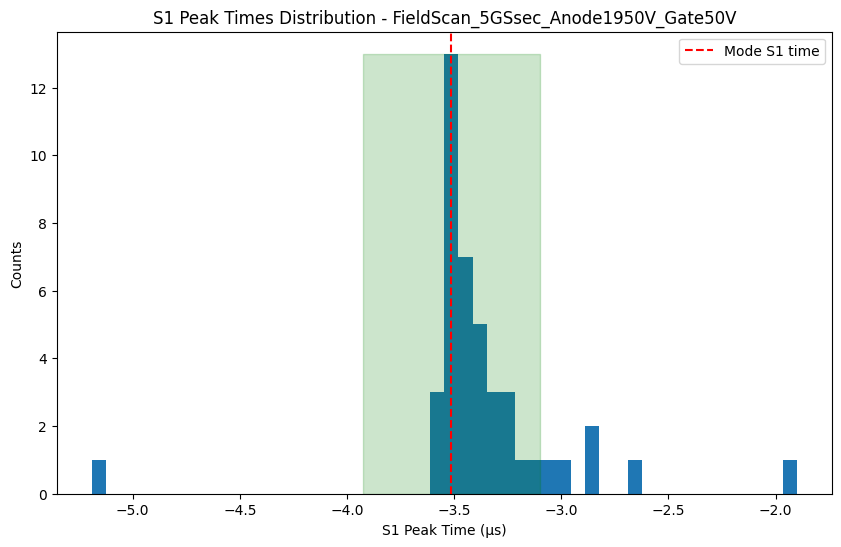

In [10]:
run5.sets[0] = constructors.estimate_s1_from_batches(run5.sets[0], batch_size=5, n_batches=50)
t_s1 = run5.sets[0].metadata['t_s1']
dt_s1 = run5.sets[0].metadata['t_s1_std']
# s1_times, t_mean, dt_mean, s1_times_clean = constructors.estimate_s1_from_batches(run5.sets[0], batch_size=20, n_batches=50)

In [67]:
i = 0

Converting time to µs for better readability


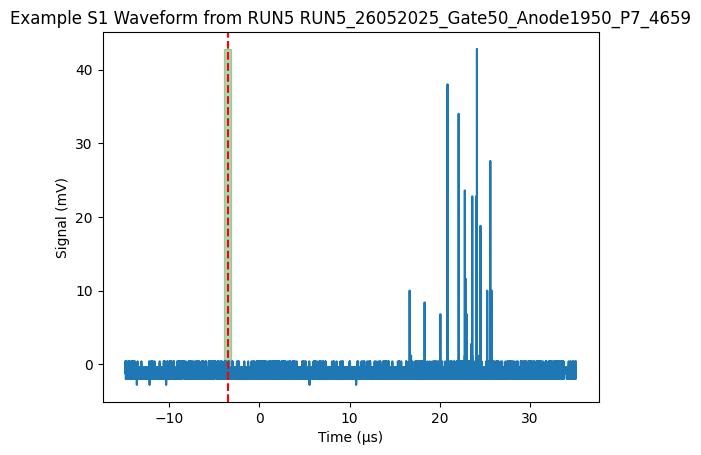

In [73]:
i += 1
wfpath = run5.sets[0].source_dir / run5.sets[0].filenames[i]
wf = dataIO.load_wfm(wfpath)
plotting.plot_waveform(wf, title="Example S1 Waveform from RUN5")
plt.axvline(t_s1, color='red', linestyle='--', label='S1')
plt.fill_betweenx([0, wf.v.max()*1e3], t_s1 - dt_s1, t_s1 + dt_s1, color='green', alpha=0.3, label='±std dev')

In [11]:
t_s1

np.float64(-3.512)

(np.float64(15.179600000000002),
 np.float64(30.7672),
 np.float64(15.587599999999997))

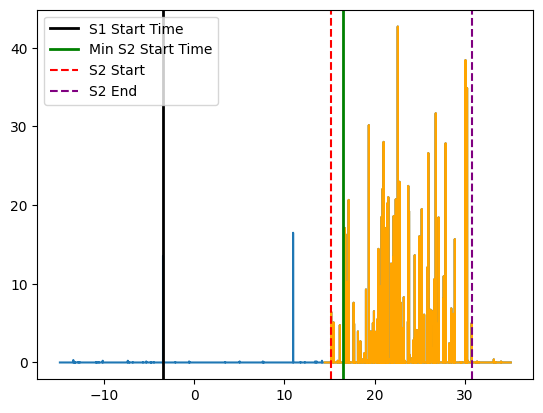

In [150]:
threshold_s2 = 0.4 # mV
set_pmt = run5.sets[0]
wfpath = run5.sets[0].source_dir / run5.sets[0].filenames[i]
i += 1
wf = dataIO.load_wfm(wfpath)
wf = transf.t_in_us(wf)
wf = transf.v_in_mV(wf)
wf = transf.moving_average(wf, window=9)
wf = transf.threshold_clip(wf, threshold=0.02)
wf = transf.subtract_pedestal(wf, n_points=200)
t, V = wf.t, wf.v
mask = t > t_s1 + set_pmt.time_drift * 0.9
s2_window = V[mask]
positive_mask = s2_window > threshold_s2

s2_start = t[mask][positive_mask][0]
s2_end = t[mask][positive_mask][-1] 

plt.plot(t, V, )
plt.plot(t[mask], V[mask], color='orange')
plt.axvline(t_s1, color='k', lw=2, linestyle='-', label='S1 Start Time')
plt.axvline(t_s1 + set_pmt.time_drift, color='green', lw=2, linestyle='-', label='Min S2 Start Time')
plt.axvline(s2_start, color='red', linestyle='--', label='S2 Start')
plt.axvline(s2_end, color='purple', linestyle='--', label='S2 End')
plt.legend()
# plt.gca().set(ylim=(-0.1, 2))
s2_start, s2_end, s2_end - s2_start

In [216]:
t_starts, t_ends, s2_durations = constructors.estimate_s2_window(run5.sets[-1], threshold_s2=0.4)
t_starts, t_ends, s2_durations

(array([7.4476, 6.62  , 5.5006, ..., 3.932 , 2.6434, 2.5386]),
 array([ 9.4574,  8.6572, 22.21  , ...,  9.362 ,  9.7876, 13.7816]),
 array([ 2.0098,  2.0372, 16.7094, ...,  5.43  ,  7.1442, 11.243 ]))

In [157]:
wf = dataIO.load_wfm(wfpath)
t_start, t_end = constructors.s2_window_pipeline(wf, t_s1, run5.sets[0].time_drift, threshold_s2=0.4)
t_start, t_end

(np.float64(15.179600000000002), np.float64(30.7672))

In [170]:
t_s1 + run5.sets[0].time_drift

np.float64(16.463595667979597)

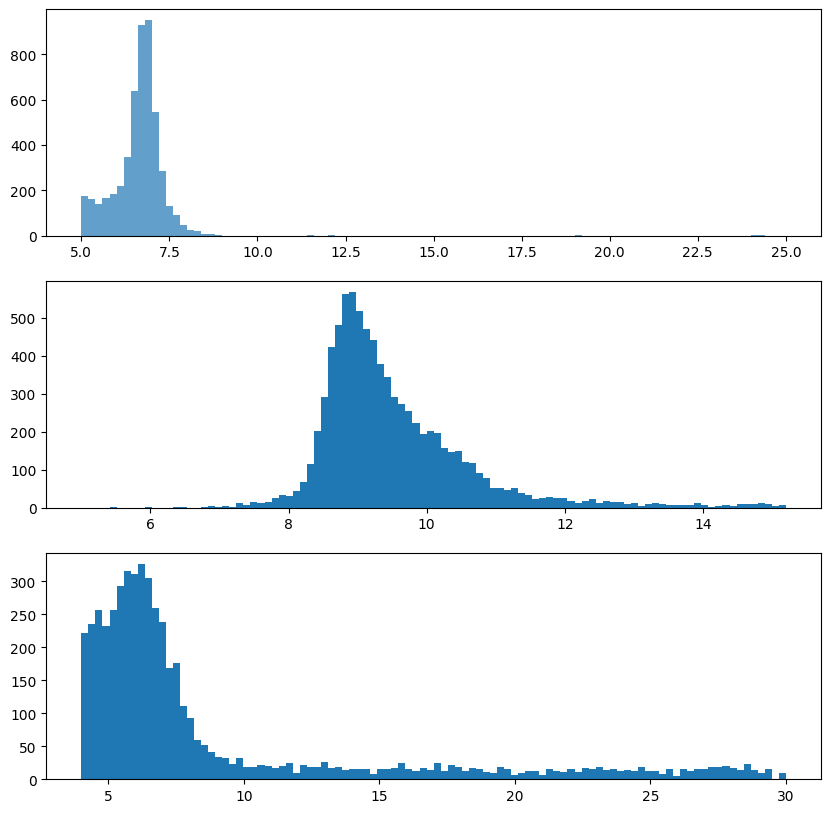

In [223]:
fig, ax = plt.subplots(3, figsize=(10,10))

n, bins, _ = ax[0].hist(t_starts, bins=100, alpha=0.7, range=(5, 25), label='S2 Start Times')
# n, bins, _ = ax[0].hist(t_starts, bins=100, range=(6, 7), label='S2 Start Times')

n, bins, _ = ax[1].hist(t_ends, bins=100, range=(5, 15.2), label='S2 End Times')
n, bins, _ = ax[2].hist(s2_durations, bins=100, range=(4, 30), label='S2 Durations')
# n, bins, _ = ax[2].hist(s2_durations, bins=100, range=(20, 30.7), label='S2 Durations')


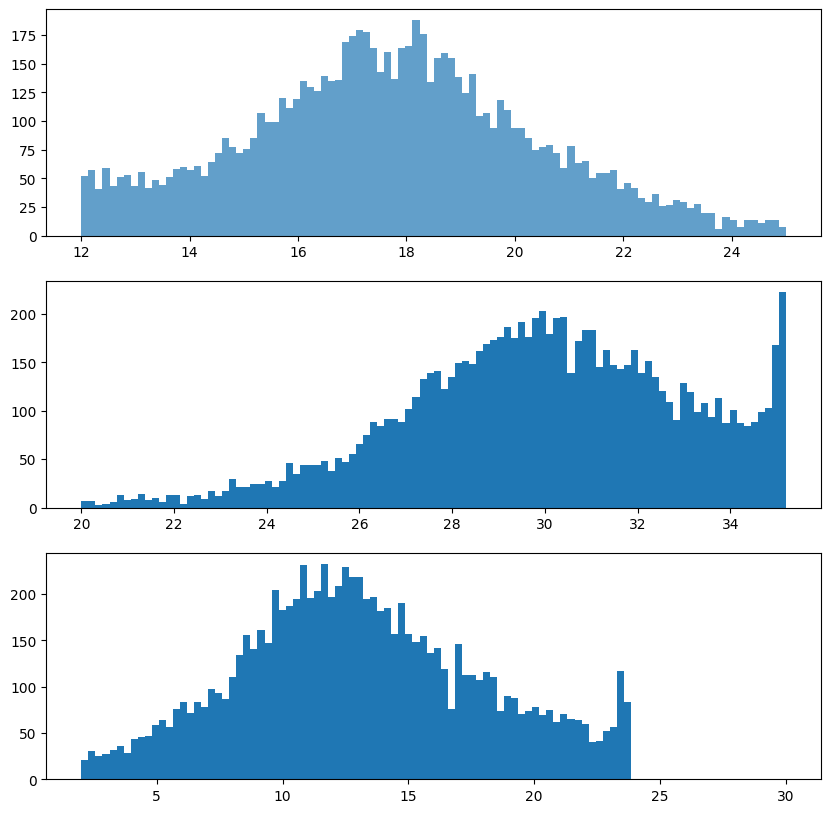

In [ ]:
fig, ax = plt.subplots(3, figsize=(10,10))

n, bins, _ = ax[0].hist(t_starts, bins=100, alpha=0.7, range=(12, 25), label='S2 Start Times')
# n, bins, _ = ax[0].hist(t_starts, bins=100, range=(6, 7), label='S2 Start Times')

n, bins, _ = ax[1].hist(t_ends, bins=100, range=(20, 35.2), label='S2 End Times')
n, bins, _ = ax[2].hist(s2_durations, bins=100, range=(2, 30), label='S2 Durations')
# n, bins, _ = ax[2].hist(s2_durations, bins=100, range=(20, 30.7), label='S2 Durations')


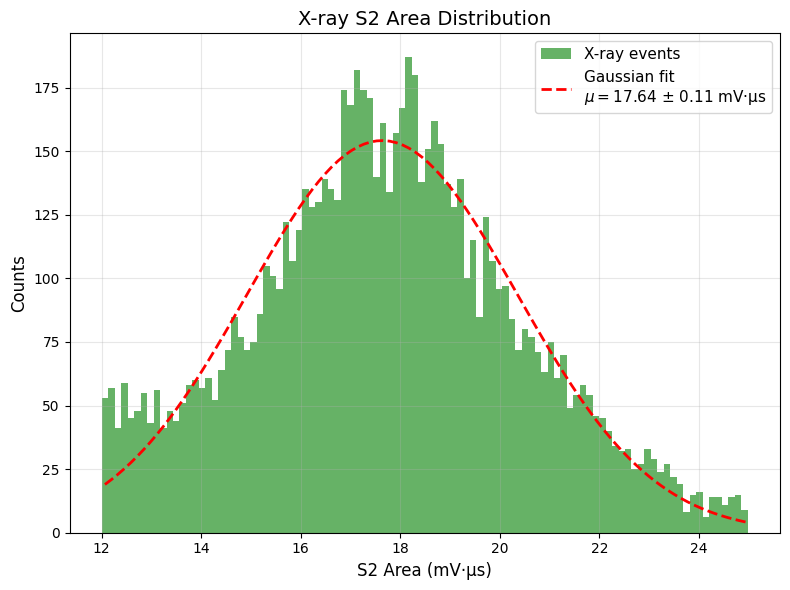

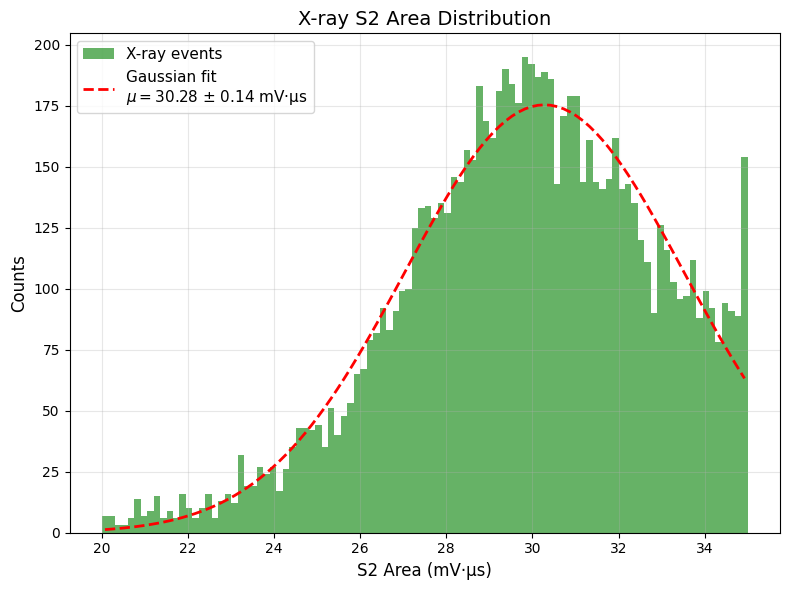

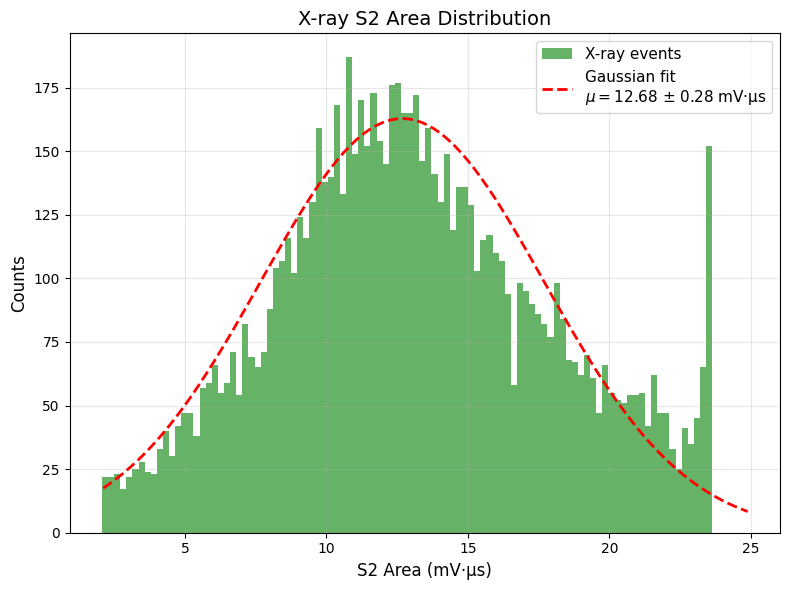

In [192]:
start_mean, start_std, _ = fit_xray_histogram(t_starts, bin_cuts=(12, 25), flag_plot=True)
end_mean, end_std, _ = fit_xray_histogram(t_ends, bin_cuts=(20, 35), flag_plot=True)
s2_mean, s2_std, s2_ci95 = fit_xray_histogram(s2_durations, bin_cuts=(2, 25), flag_plot=True)


Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability
Converting time to µs for better readability


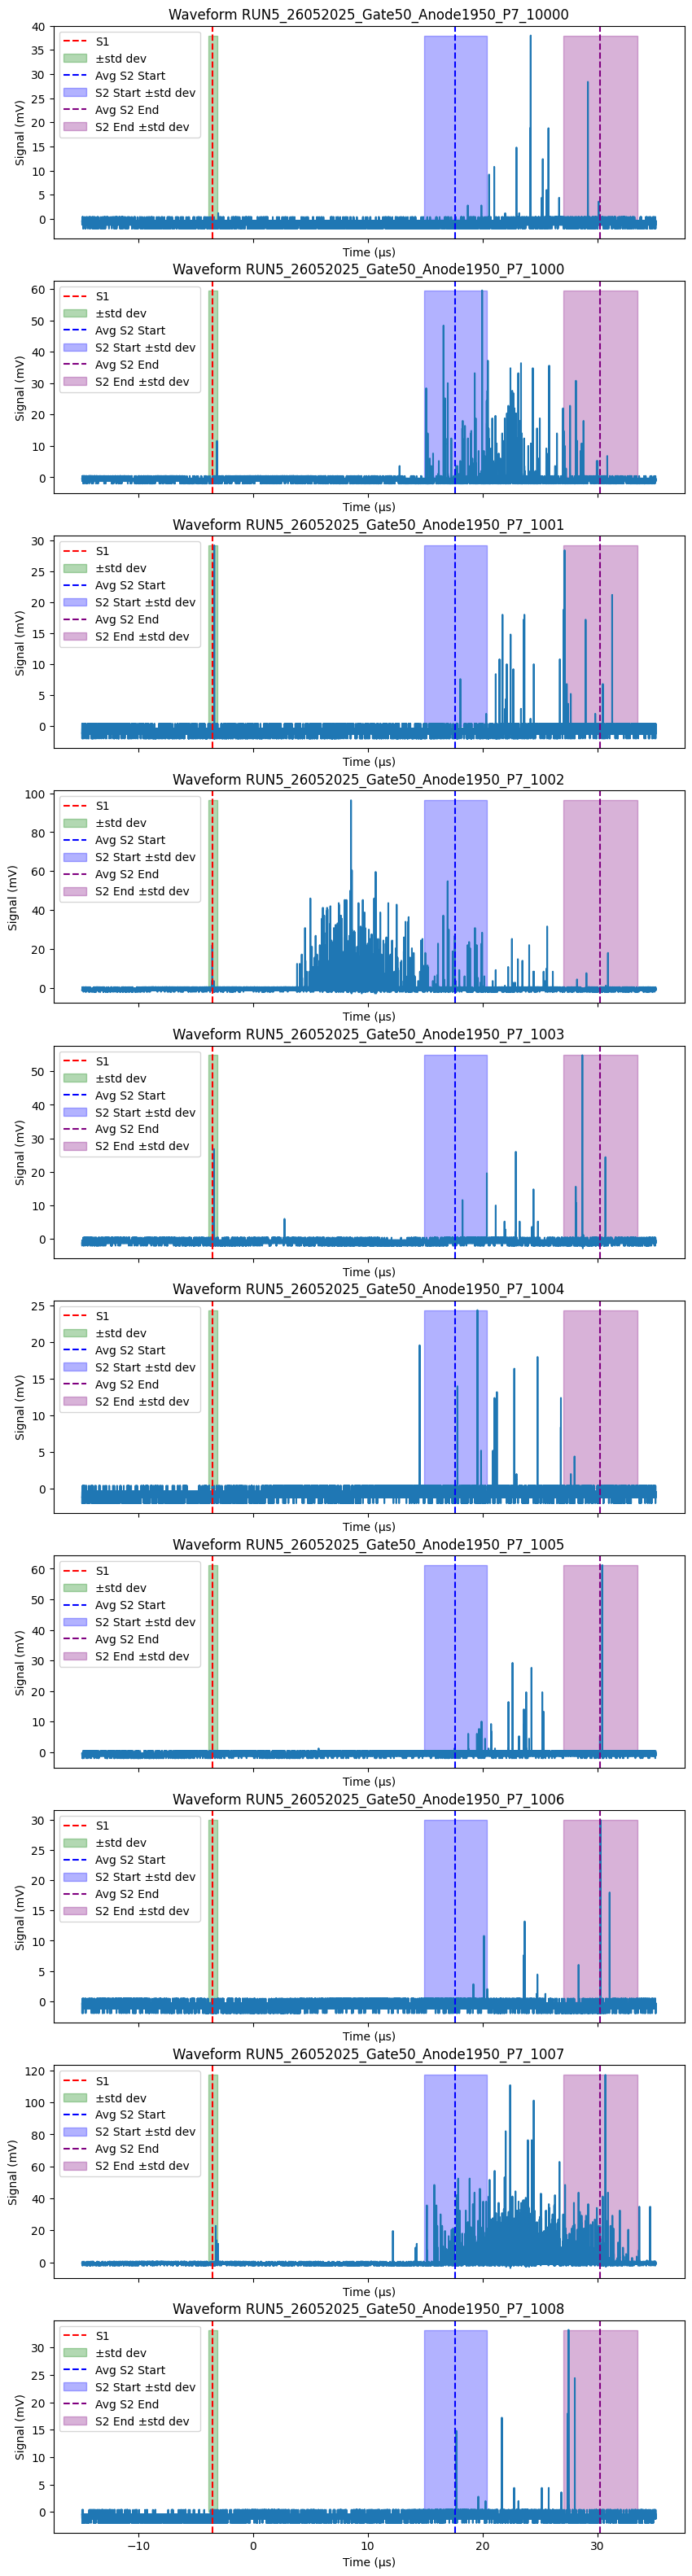

In [191]:
batch_size = 10
batch0 = batch_filenames(set_pmt.filenames, batch_size).__next__()
fig, ax = plt.subplots(len(batch0), 1, figsize=(10, 40), sharex=True)
for i, fn in enumerate(batch0):
    wf = dataIO.load_wfm(set_pmt.source_dir / fn)
    plotting.plot_waveform(wf, ax=ax[i], )
    # ax[i].set(title=f"Waveform: {fn}")
    ax[i].axvline(t_s1, color='red', linestyle='--', label='S1')
    ax[i].fill_betweenx([0, wf.v.max()*1e3], t_s1 - dt_s1, t_s1 + dt_s1, color='green', alpha=0.3, label='±std dev')
    ax[i].axvline(start_mean, color='blue', linestyle='--', label='Avg S2 Start')
    ax[i].fill_betweenx([0, wf.v.max()*1e3], start_mean - start_std, start_mean + start_std, color='blue', alpha=0.3, label='S2 Start ±std dev')
    ax[i].axvline(end_mean, color='purple', linestyle='--', label='Avg S2 End')
    ax[i].fill_betweenx([0, wf.v.max()*1e3], end_mean - end_std, end_mean + end_std, color='purple', alpha=0.3, label='S2 End ±std dev')

    ax[i].legend()

In [193]:
# Clean the duration distribution
duration_clean = s2_durations[(s2_durations > 8) & (s2_durations < 22)]

# Robust central value and spread
median_duration = np.median(duration_clean)
mad_duration = 1.4826 * np.median(np.abs(duration_clean - median_duration))

# Or use percentiles for Gaussian-like core
p16, p50, p84 = np.percentile(duration_clean, [16, 50, 84])
sigma_duration_lower = p50 - p16
sigma_duration_upper = p84 - p50
sigma_duration_avg = (sigma_duration_upper + sigma_duration_lower) / 2

print(f"Median duration: {p50:.2f} ± {sigma_duration_avg:.2f} µs")
print(f"MAD-based spread: {median_duration:.2f} ± {mad_duration:.2f} µs")
print(f"Gaussian fit mean and spread: {s2_mean:.2f} ± {s2_ci95:.2f} µs")

Median duration: 13.29 ± 3.94 µs
MAD-based spread: 13.29 ± 3.86 µs
Gaussian fit mean and spread: 12.68 ± 0.28 µs


## Compute spread in run

In [230]:
spread_run = constructors.s2_variance_run(run5, s2_duration_cuts=(5, 25))

Processing set: FieldScan_5GSsec_Anode1950V_Gate50V
Processing set: FieldScan_5GSsec_Anode2000V_Gate100V
Processing set: FieldScan_5GSsec_Anode2100V_Gate200V
Processing set: FieldScan_5GSsec_Anode2500V_Gate600V
Processing set: FieldScan_5GSsec_Anode3000V_Gate1100V
Processing set: FieldScan_5GSsec_Anode3500V_Gate1600V
Processing set: FieldScan_5GSsec_Anode4000V_Gate2100V


In [264]:
sigma_obs = []
drift_times = []
drift_fields = []
speeds_drift_squared = []
for s in run5.sets:
    print(f"Set: {s.source_dir.name}, Sigma Duration: {spread_run[s.source_dir.name]:.2f} µs")
    sigma_obs.append(spread_run[s.source_dir.name]**2)
    drift_times.append(s.time_drift)
    drift_fields.append(s.drift_field)
    speeds_drift_squared.append(s.speed_drift**2)
drift_times = np.array(drift_times)
speeds_drift_squared = np.array(speeds_drift_squared)
drift_fields = np.array(drift_fields)

Set: FieldScan_5GSsec_Anode1950V_Gate50V, Sigma Duration: 4.74 µs
Set: FieldScan_5GSsec_Anode2000V_Gate100V, Sigma Duration: 5.63 µs
Set: FieldScan_5GSsec_Anode2100V_Gate200V, Sigma Duration: 6.77 µs
Set: FieldScan_5GSsec_Anode2500V_Gate600V, Sigma Duration: 6.92 µs
Set: FieldScan_5GSsec_Anode3000V_Gate1100V, Sigma Duration: 6.68 µs
Set: FieldScan_5GSsec_Anode3500V_Gate1600V, Sigma Duration: 6.16 µs
Set: FieldScan_5GSsec_Anode4000V_Gate2100V, Sigma Duration: 3.93 µs


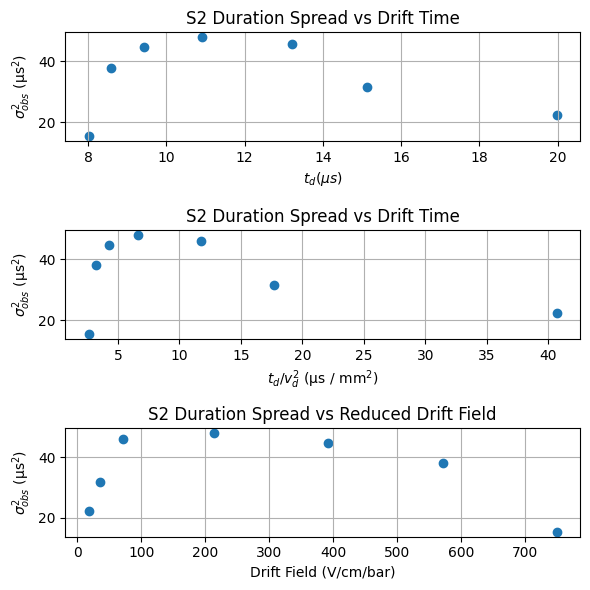

In [267]:
fig, ax = plt.subplots(3, figsize=(6,6))

ax[0].scatter(drift_times, sigma_obs)
ax[0].set(xlabel="$t_d (µs)$", ylabel="$\sigma_{obs}^2$ (µs$^2$)", title="S2 Duration Spread vs Drift Time")


ax[1].scatter(drift_times/speeds_drift_squared, sigma_obs)
ax[1].set(xlabel="$t_d / v_d^2$ (µs / mm$^2$)", ylabel="$\sigma_{obs}^2$ (µs$^2$)", title="S2 Duration Spread vs Drift Time")

ax[2].scatter(drift_fields/run5.pressure, sigma_obs)
ax[2].set(xlabel="Drift Field (V/cm/bar)", ylabel="$\sigma_{obs}^2$ (µs$^2$)", title="S2 Duration Spread vs Reduced Drift Field")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.tight_layout()

In [250]:
linear_fit = np.polyfit(drift_times, sigma_obs, 1)
m, b = linear_fit
print(f"Linear fit: sigma_obs^2 = {m:.4f} * t_drift + {b:.4f}")

Linear fit: sigma_obs^2 = -3.0056 * t_drift + 81.4876


In [253]:
D_L = [m * speed**2 / 2 for speed in speeds]
D_L

[np.float64(-0.7381817440417437),
 np.float64(-1.2854396797093985),
 np.float64(-1.6879914383885302),
 np.float64(-2.4769245468759604)]

# Diffusion analysis

In [ ]:
sigma_duration_avg

np.float64(3.9434520000000024)

In [215]:
# Expected from Magboltz/literature for your E/p
D_L_theory = 10  # cm²/s (example, lookup your value)
t_drift_s = run5.sets[0].time_drift * 1e-6  # convert µs to s
sigma_diff_theory_cm = np.sqrt(2 * D_L_theory * t_drift_s)  # cm

# Convert to time using drift velocity
v_drift_cm_per_s = run5.sets[0].speed_drift * 1e-1 * 1e6  # mm/µs → cm/s
sigma_diff_theory_us = sigma_diff_theory_cm / v_drift_cm_per_s * 1e6  # to µs

print(f"Observed σ_diff: {sigma_duration_avg:.2f} µs")
print(f"Expected σ_diff: {sigma_diff_theory_us:.2f} µs")

Observed σ_diff: 3.94 µs
Expected σ_diff: 0.29 µs


In [211]:
gd = transport.gas_density_cm3(run5.pressure, run5.temperature)
set_pmt.red_drift_field, set_pmt.drift_field / gd * 1e17  # in Td
[s.red_drift_field / run5.pressure for s in run5.sets]

[0.036611852946428575,
 0.07322370589285715,
 0.1464474117857143,
 0.439342235357143,
 0.8054607648214287,
 1.1715792942857144,
 1.53769782375]